In [1]:
import json
from pathlib import Path
import uvicorn
import pandas as pd
import torch
from fastapi import FastAPI, HTTPException, Request
from fastapi.middleware.cors import CORSMiddleware
from pathlib import Path
import torch
import numpy as np
from src.models import MLP
from src.util import Data
import os


MODEL_PATH = Path("../model/mlp.pt")
BEER_PATH = Path("../data/beers_metadata.csv")

assert os.path.exists(MODEL_PATH)
assert os.path.exists(BEER_PATH)

app = FastAPI()
beer_data = pd.read_csv(BEER_PATH)

origins = ["http://localhost", "http://localhost:8080", "http://localhost:5000/"]

app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)
RATINGS_PATH = Path("../data/ratings.csv")
MODEL_PATH = Path("../model/mlp.pt")

assert os.path.exists(RATINGS_PATH)
assert os.path.exists(MODEL_PATH)

data = Data(RATINGS_PATH)

device = torch.device(
            'cuda' if torch.cuda.is_available() else 'cpu'
        )


user_encoder = data.user_encoder
beer_encoder = data.beer_encoder
#model = DummyModel()
model = MLP(
    user_dim=data.user_count,
    beer_dim=data.beer_count,
    n_factors=10,
    n_layers=0,
    interactions=data.train_interactions,
    user_encoder=data.user_encoder,
    beer_encoder=data.beer_encoder,
    max_rating=data.max_rating,
    learning_rate=1e-3,
    weight_decay=1e-6
)
model.load_state_dict(torch.load(MODEL_PATH))
model=model.to(device)
model.eval()


ratings = pd.read_csv(RATINGS_PATH)

popular_beer= ratings.groupby("beer_id",as_index=False).count()
beer_data= beer_data.join(popular_beer,on="beer_id",rsuffix="count_")



Building interaction matrix:   0%|          | 0/243264 [00:00<?, ?it/s]

In [2]:
import matplotlib.pyplot as plt

In [3]:
beers_1 = np.array(model.predict(2201))

ilosc piw 9153
ilosc piw drunk 1587
7566
wyjscie z modelu [3229 5762 9553 ... 3802 3591 5753] [4.84825909 4.82141525 4.81604874 ... 1.32259831 1.17566176 1.17345624]


In [4]:
beers_2 = np.array(model.predict(12447))

ilosc piw 9153
ilosc piw drunk 1358
7795
wyjscie z modelu [9208 8995 9553 ... 9689 3581 3754] [4.88493681 4.87128377 4.86490726 ... 1.5506126  1.43665299 1.39578879]


In [7]:
x=(beers_1 == beers_2)

<ipython-input-7-f85e0c553915>:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  x=(beers_1 == beers_2)


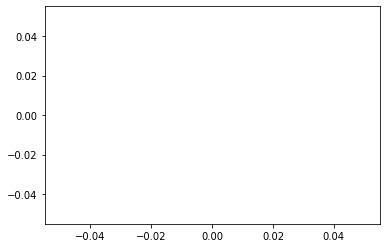

In [8]:
plt.plot(x)

In [52]:
@torch.no_grad()
def predict_ratings(model, user_id: int) -> Tuple[np.ndarray, np.ndarray]:
    user_id = model.user_encoder.transform([user_id])[0]

    beers = set(range(model.beer_encoder.classes_.size))
    print("ilosc piw",len(beers))
    beers_drinked = model.interactions[user_id].nonzero()
    print("ilosc piw drunk", len(beers_drinked))
    if len(beers_drinked):
        beers_drinked = set(beers_drinked.flatten().numpy())
    else:
        beers_drinked = set()
    print(beers_drinked)
    print("should be", len(beers)-len(beers_drinked))
    beers = beers.difference(beers_drinked)
    beers = list(beers)
    print("after",len(beers))

    beers = torch.LongTensor(beers).to(model.predict_device)
    user = torch.LongTensor([user_id] * len(beers)).to(model.predict_device)

    ratings = model.forward(user, beers)
    ratings = ratings.cpu().numpy()
    beers = beers.cpu().numpy()

    ranking = pd.DataFrame(zip(beers, ratings), columns=["beer", "rating"])
    ranking = ranking.sort_values(by="rating", ascending=False)

    beers = ranking.beer.values
    ratings = ranking.rating.values

    beers = model.beer_encoder.inverse_transform(beers)
    ratings *= model.MAX_RATING
    # ratings = self.rating_encoder.inverse_transform(ratings)
    print("wyjscie z modelu",beers,ratings)
    return beers, ratings

In [53]:
from abc import abstractmethod
from typing import List, Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from pytorch_lightning import LightningModule
from sklearn.preprocessing import LabelEncoder

from src.models.recommender import Recommender

In [54]:
predict_ratings(model,2201)

ilosc piw 9153
ilosc piw drunk 1587
{0, 8193, 3, 6, 8204, 14, 15, 16, 8211, 22, 24, 8217, 29, 30, 32, 34, 8226, 36, 8227, 38, 40, 43, 46, 47, 54, 8248, 8250, 8253, 64, 8256, 67, 8260, 69, 70, 71, 72, 81, 8276, 85, 8277, 8280, 89, 93, 8288, 98, 99, 100, 101, 102, 8294, 8297, 8300, 8301, 8302, 111, 112, 8305, 8314, 124, 130, 132, 133, 135, 136, 138, 8339, 8340, 153, 8346, 8348, 8349, 158, 160, 161, 8354, 163, 164, 165, 8356, 167, 168, 169, 175, 8372, 182, 8374, 184, 8381, 190, 200, 201, 8393, 8395, 204, 8396, 207, 8400, 209, 212, 214, 216, 221, 222, 8419, 8420, 231, 232, 233, 8424, 235, 236, 8425, 238, 8429, 8435, 8436, 8438, 8441, 252, 257, 8449, 8451, 8455, 8456, 8457, 8459, 8460, 8463, 8464, 8465, 275, 276, 8467, 8468, 279, 280, 8469, 285, 286, 8477, 294, 295, 296, 8486, 8488, 8489, 301, 302, 303, 8497, 306, 8499, 308, 310, 8505, 315, 8510, 8516, 326, 8518, 8522, 8524, 8528, 8530, 339, 343, 8535, 8537, 8538, 8539, 349, 8542, 353, 8546, 8551, 365, 366, 8557, 8558, 8562, 8564, 374, 8567

(array([3229, 5762, 9553, ..., 3802, 3591, 5753], dtype=int64),
 array([4.84825909, 4.82141525, 4.81604874, ..., 1.32259831, 1.17566176,
        1.17345624]))